# Imports

In [26]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from skimage.metrics import structural_similarity as ssim
import cv2
import shutil

# Extract the data

In [13]:
path_to_Train = r'C:\Users\LENOVO\Desktop\SAR\cuda\data'
path_to_Test = r'C:\Users\LENOVO\Desktop\SAR\cuda\data'
def load_images_from_folders(base_dir, num_images=3):
    images = []
    for pair_folder in sorted(os.listdir(base_dir)):
        pair_path = os.path.join(base_dir, pair_folder)
        if os.path.isdir(pair_path):
            pair_number = pair_folder.split('-')[-1]
            sar_image_filename = f'sar-image-{pair_number}.jpg'
            sar_image_path = os.path.join(pair_path, sar_image_filename)
            if os.path.isfile(sar_image_path):
                sar_image = cv2.imread(sar_image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
                if sar_image is not None:
                    images.append(sar_image)
                    if len(images) >= num_images:
                        break
                else:
                    print(f"Failed to load image: {sar_image_path}")
            else:
                print(f"SAR image file not found: {sar_image_path}")
    return images
train_list = load_images_from_folders(path_to_Train)
test_list = load_images_from_folders(path_to_Test)
print(f"Number of training images loaded: {len(train_list)}")
print(f"Number of testing images loaded: {len(test_list)}")

Number of training images loaded: 3
Number of testing images loaded: 3


# Create the dataset & preprocessing

In [38]:
img_size = 128
max_patches_train = 0
for train_image in train_list:
    num_patches_x = train_image.shape[0] // img_size
    num_patches_y = train_image.shape[1] // img_size
    max_patches_train += num_patches_x * num_patches_y
X_train = np.zeros((max_patches_train, img_size, img_size))
patch_index = 0
for train_image in train_list:
    num_patches_x = train_image.shape[0] // img_size
    num_patches_y = train_image.shape[1] // img_size
    for i in range(num_patches_x):
        for j in range(num_patches_y):
            patch = train_image[i * img_size:(i + 1) * img_size, j * img_size:(j + 1) * img_size]
            X_train[patch_index] = patch
            patch_index += 1
print("Shape of the training set is: ", X_train.shape)
max_patches_test = 0
for test_image in test_list:
    num_patches_x = test_image.shape[0] // img_size
    num_patches_y = test_image.shape[1] // img_size
    max_patches_test += num_patches_x * num_patches_y
X_test = np.zeros((max_patches_test, img_size, img_size))
patch_index = 0
for test_image in test_list:
    num_patches_x = test_image.shape[0] // img_size
    num_patches_y = test_image.shape[1] // img_size
    for i in range(num_patches_x):
        for j in range(num_patches_y):
            patch = test_image[i * img_size:(i + 1) * img_size, j * img_size:(j + 1) * img_size]
            X_test[patch_index] = patch
            patch_index += 1
print("Shape of the testing set is: ", X_test.shape)

Shape of the training set is:  (741, 128, 128)
Shape of the testing set is:  (741, 128, 128)


## Addition of noise

In [40]:
def normalize_SAR(images, log=False):
    M = 10.089038980848645
    m = -1.429329123112601
    images = images.astype(float)
    if log:
        images = ((np.log1p(images) - m) * 255) / (M - m)
    else:
        images = ((images - np.exp(m)) * 255) / (np.exp(M) - np.exp(m))
    images = np.clip(images, 0, 255).astype(np.uint8)
    return images
X_train_normalized = normalize_SAR(X_train, log=True)
X_test_normalized = normalize_SAR(X_test, log=True)
print("Shape of normalized training set: ", X_train_normalized.shape)
print("Shape of normalized testing set: ", X_test_normalized.shape)

Shape of normalized training set:  (741, 128, 128)
Shape of normalized testing set:  (741, 128, 128)


In [39]:
def injectspeckle_amplitude(imgs, L, sing_im=False):
    if sing_im:
        rows, columns = imgs.shape
        s = np.zeros((rows, columns))
        for _ in range(L):
            gamma = np.abs(np.random.randn(rows, columns) + np.random.randn(rows, columns) * 1j) ** 2 / 2
            s += gamma
        s_amplitude = np.sqrt(s / L)
        ima_speckle_amplitude = imgs * s_amplitude
    else:
        n_imgs, rows, columns = imgs.shape
        s = np.zeros((n_imgs, rows, columns))
        for _ in range(L):
            gamma = np.abs(np.random.randn(n_imgs, rows, columns) + np.random.randn(n_imgs, rows, columns) * 1j) ** 2 / 2
            s += gamma
        s_amplitude = np.sqrt(s / L)
        ima_speckle_amplitude = imgs * s_amplitude
    return ima_speckle_amplitude
L = 1
X_train_couples = np.tile(X_train, (2, 1, 1, 1))
X_test_couples = np.tile(X_test, (2, 1, 1, 1))
X_train_couples[1, :, :, :] = injectspeckle_amplitude(X_train_couples[1, :, :, :], L=L, sing_im=False)
X_test_couples[1, :, :, :] = injectspeckle_amplitude(X_test_couples[1, :, :, :], L=L, sing_im=False)
print("Shape of the training couples:", X_train_couples.shape)
print("Shape of the testing couples:", X_test_couples.shape)

Shape of the training couples: (2, 741, 128, 128)
Shape of the testing couples: (2, 741, 128, 128)


## Visualize and save the denoised/noisy images

True image


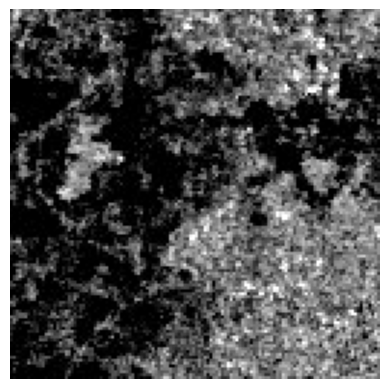

Noisy image


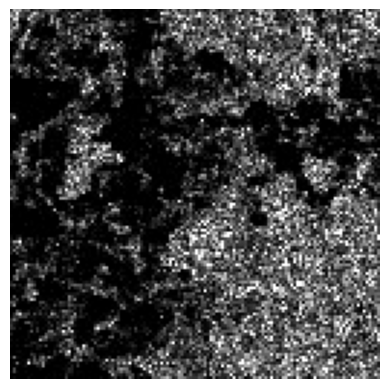

True image


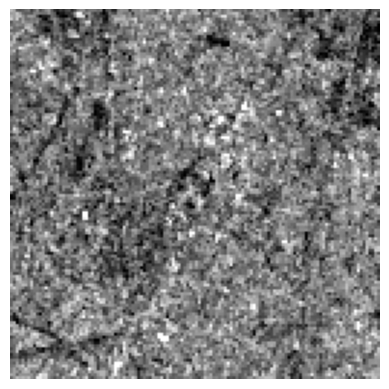

Noisy image


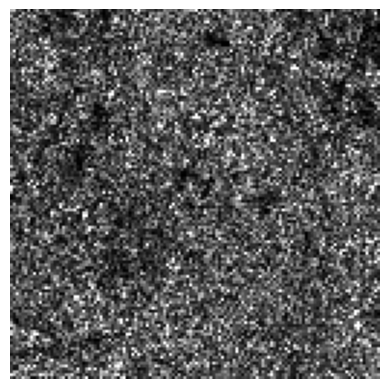

True image


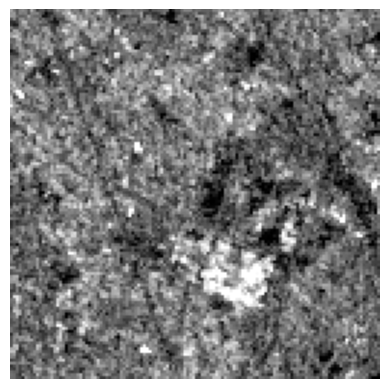

Noisy image


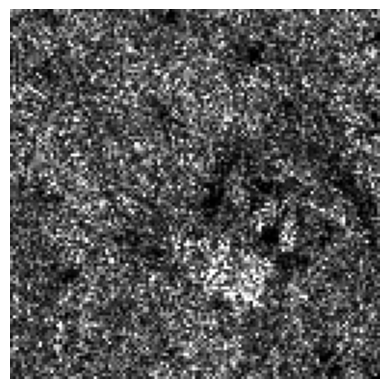

In [41]:
def plot_SAR(np_array, log=False):
    M = 10.089038980848645
    m = -1.429329123112601
    dim = np_array
    dim = np.squeeze(dim)
    threshold = np.mean(dim) + 3 * np.std(dim)
    dim = np.clip(dim, 0, threshold)
    dim = (dim / threshold) * 255
    dim = Image.fromarray(dim.astype('float64')).convert('L')
    plt.imshow(dim, cmap="gray", vmin=0, vmax=255)
    plt.axis('off')  # Hide axis
    plt.show()
for i in [1, 12, 25]:
    print("True image")
    plot_SAR(X_train_couples[0, i, :, :])
    print("Noisy image")
    plot_SAR(X_train_couples[1, i, :, :])

In [45]:
def save_SAR(np_array, name, add_speckle=False):
    M = 10.089038980848645
    m = -1.429329123112601
    dim = np_array
    dim = np.squeeze(dim)
    threshold = np.mean(dim) + 3 * np.std(dim)
    dim = np.clip(dim, 0, threshold)
    dim = (dim / threshold) * 255
    if add_speckle:
        dim = injectspeckle_amplitude(dim, L=1, sing_im=True)
    dim = Image.fromarray(dim.astype('float64')).convert('L')
    dim.save(name)
if os.path.exists('trainsets'):
    os.system('rm -rf trainsets')
os.makedirs('trainsets/trainH', exist_ok=True)
for i in range(X_train_couples.shape[1]):
    name = f"trainsets/trainH/im{i}.bmp"
    save_SAR(X_train_couples[0, i, :, :], name=name)
if os.path.exists('testsets'):
    os.system('rm -rf testsets')
os.makedirs('testsets/bsd68', exist_ok=True)
for i in range(X_test_couples.shape[1]):
    name = f"testsets/bsd68/im{i}.bmp"
    save_SAR(X_test_couples[0, i, :, :], name=name)

# Denoising 

In [46]:
def create_dir(directory):
    try:
        os.makedirs(directory, exist_ok=True)
        print(f"Created directory: {directory}")
    except Exception as e:
        print(f"Error creating directory {directory}: {e}")

# Remove existing testsets directory and create a new one
testsets_dir = "testsets"
bsd68_dir = os.path.join(testsets_dir, "bsd68")

if os.path.exists(testsets_dir):
    shutil.rmtree(testsets_dir)
create_dir(testsets_dir)
create_dir(bsd68_dir)

# Save noisy images
for i in range(X_test_couples.shape[1]):
    name = os.path.join(bsd68_dir, f"im{i}.bmp")
    save_SAR(X_test_couples[1, i, :, :], name=name, add_speckle=True)

print("\nDenoised with the uniform noise map method\n")
# Denoising with uniform noise map
os.system('python main_test_ffdnet.py')

print("\nDenoised with the LM method\n")
# Denoising with Local Means
os.system('python main_test_ffdnet_LM.py')

print("\nDenoised with the Oracle method\n")
# Denoising with the Oracle Method
os.system('python main_test_ffdnet_oracle.py')


Created directory: testsets
Created directory: testsets\bsd68

Denoised with the uniform noise map method


Denoised with the LM method


Denoised with the Oracle method



2

# Show the results

In [47]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def plot_results(model_name, ind_im=0, real_name="no"):
    if real_name == "no":
        print(f"\n Image {ind_im} \n")
        print("Noisy")
        plot_SAR(X_test_couples[1, ind_im, :, :])
        print("True")
        plot_SAR(X_test_couples[0, ind_im, :, :])
        print("Denoised")
        denoised_image_path = f"results/bsd68_{model_name}/im{ind_im}.bmp"
        try:
            im = Image.open(denoised_image_path)
            plt.imshow(np.array(im).astype(int), cmap="gray", vmin=0, vmax=255)
            plt.show()
        except FileNotFoundError:
            print(f"Error: File {denoised_image_path} not found.")
    else:
        print(f"\n{real_name} \n")
        print("Noisy")
        noisy_image_path = f"testsets/bsd68/{real_name}.bmp" if real_name != "terrasar" else f"testsets/bsd68/{real_name}.jpg"
        try:
            im = Image.open(noisy_image_path)
            plt.imshow(np.array(im).astype(int), cmap="gray", vmin=0, vmax=255)
            plt.show()
        except FileNotFoundError:
            print(f"Error: File {noisy_image_path} not found.")
        print("Denoised")
        denoised_image_path = f"results/bsd68_{model_name}/{real_name}.bmp" if real_name != "terrasar" else f"results/bsd68_{model_name}/{real_name}.jpg"
        try:
            im = Image.open(denoised_image_path)
            plt.imshow(np.array(im).astype(int), cmap="gray", vmin=0, vmax=255)
            plt.show()
        except FileNotFoundError:
            print(f"Error: File {denoised_image_path} not found.")

Results with the Uniform Noise Map method

Plotting results for image 0...

 Image 0 

Noisy


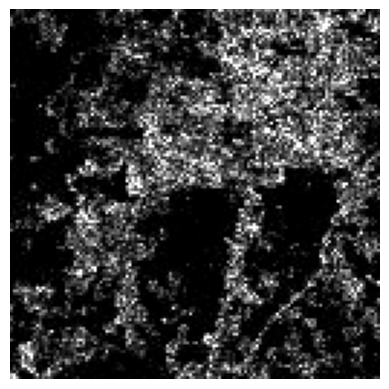

True


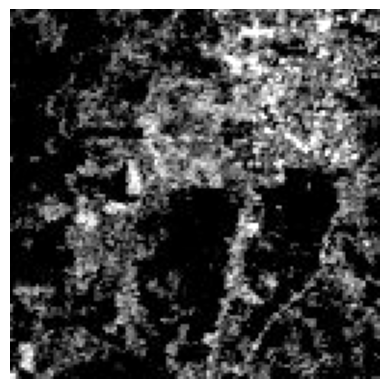

Denoised
Error: File results/bsd68_loss_L1_view_L1/im0.bmp not found.
Plotting results for image 1...

 Image 1 

Noisy


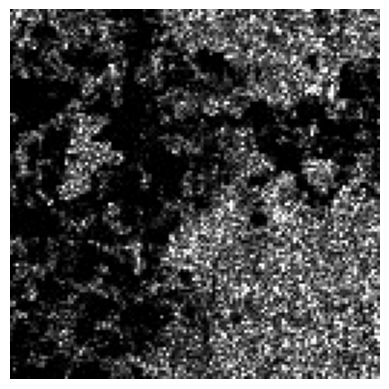

True


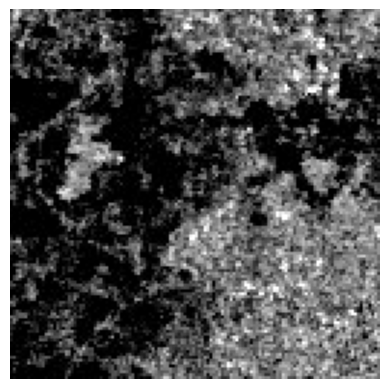

Denoised
Error: File results/bsd68_loss_L1_view_L1/im1.bmp not found.
Plotting results for image 2...

 Image 2 

Noisy


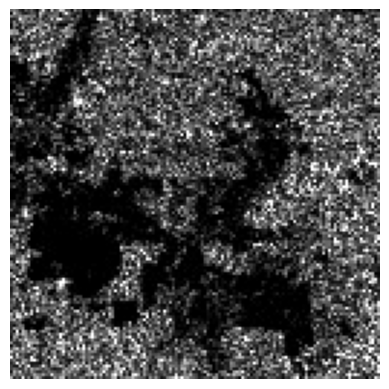

True


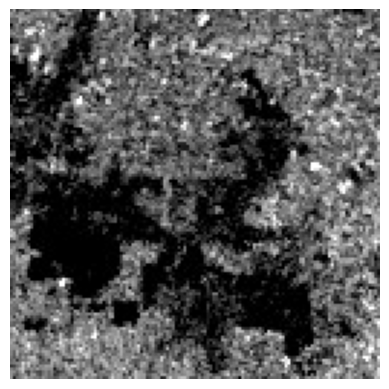

Denoised
Error: File results/bsd68_loss_L1_view_L1/im2.bmp not found.
Plotting results for image 3...

 Image 3 

Noisy


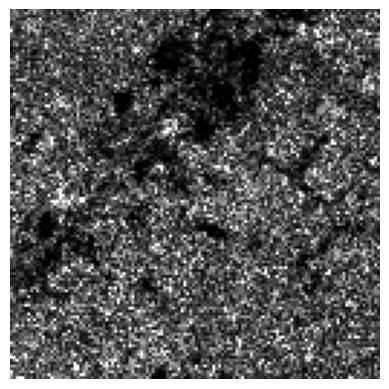

True


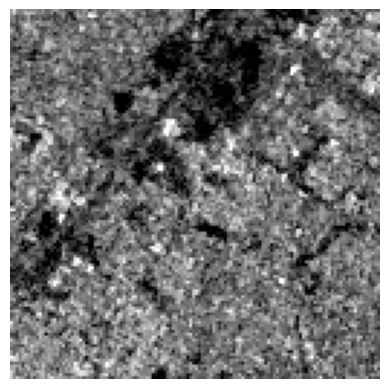

Denoised
Error: File results/bsd68_loss_L1_view_L1/im3.bmp not found.
Plotting results for image 4...

 Image 4 

Noisy


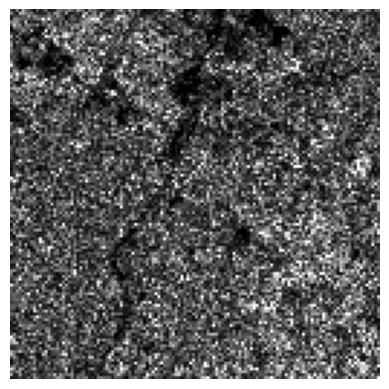

True


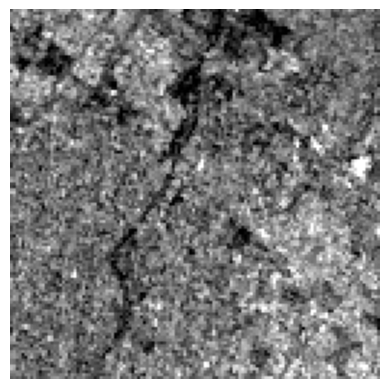

Denoised
Error: File results/bsd68_loss_L1_view_L1/im4.bmp not found.
Plotting results for image 5...

 Image 5 

Noisy


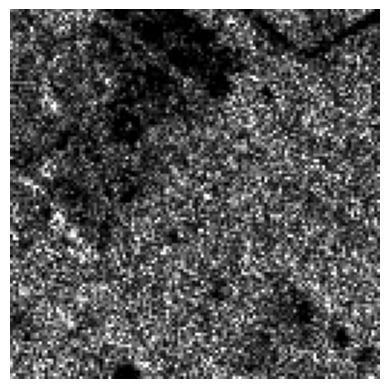

True


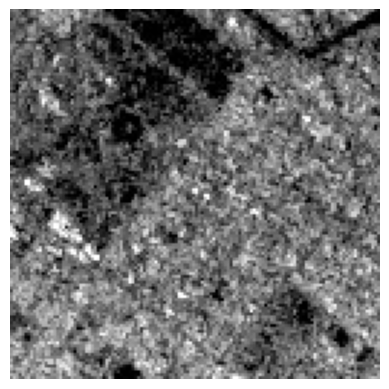

Denoised
Error: File results/bsd68_loss_L1_view_L1/im5.bmp not found.
Plotting results for image 6...

 Image 6 

Noisy


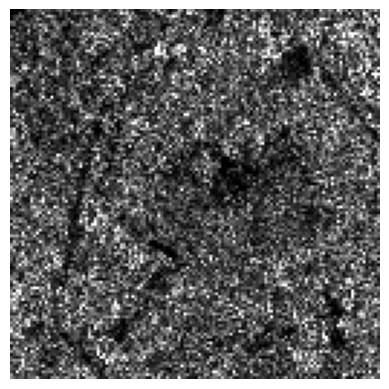

True


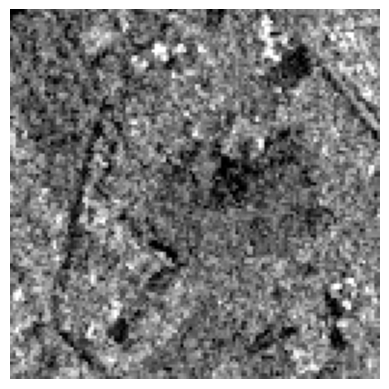

Denoised
Error: File results/bsd68_loss_L1_view_L1/im6.bmp not found.


In [48]:
model_name = "loss_L1_view_L1"
for ind_im in range(7):
    print(f"Plotting results for image {ind_im}...")
    plot_results(model_name, ind_im)

Results with the Local Means method


 Image 0 

Noisy


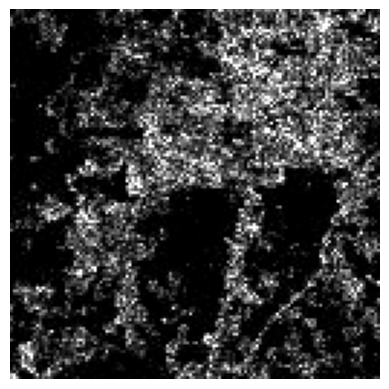

True


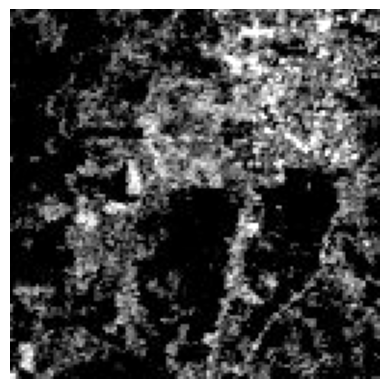

Denoised
Error: File results/bsd68_loss_L1_view_L5_LM/im0.bmp not found.

 Image 1 

Noisy


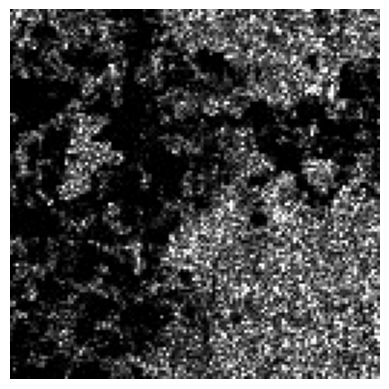

True


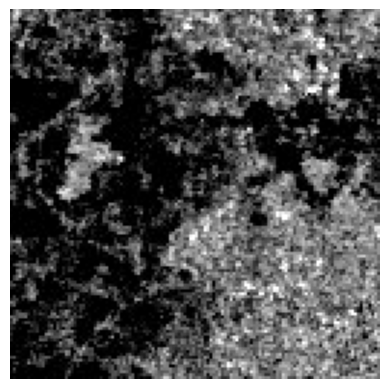

Denoised
Error: File results/bsd68_loss_L1_view_L5_LM/im1.bmp not found.

 Image 2 

Noisy


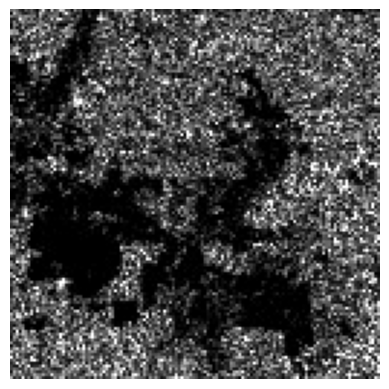

True


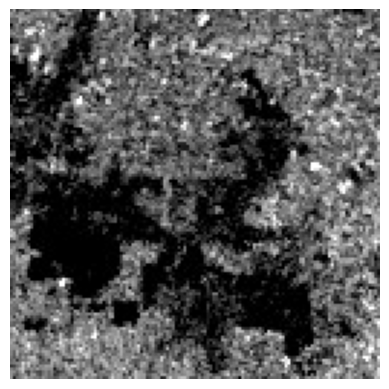

Denoised
Error: File results/bsd68_loss_L1_view_L5_LM/im2.bmp not found.

 Image 3 

Noisy


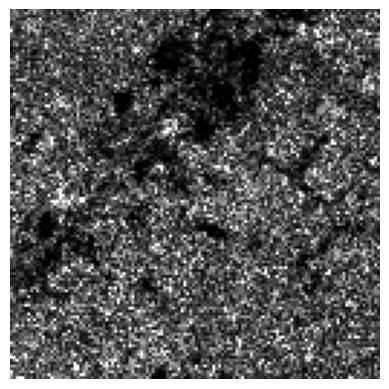

True


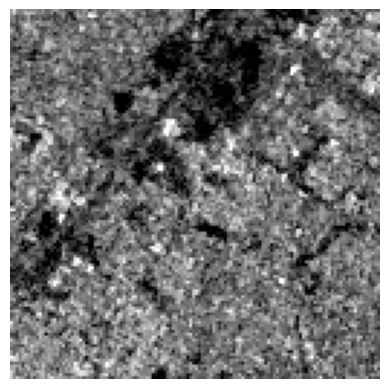

Denoised
Error: File results/bsd68_loss_L1_view_L5_LM/im3.bmp not found.

 Image 4 

Noisy


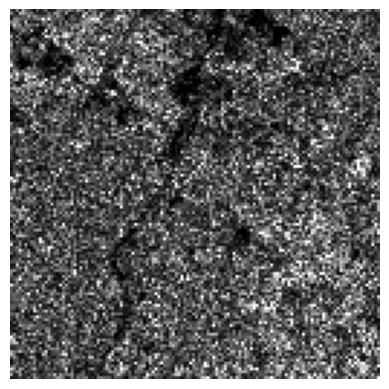

True


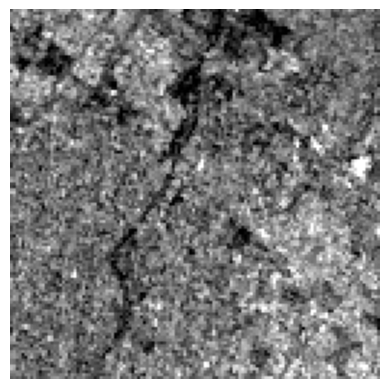

Denoised
Error: File results/bsd68_loss_L1_view_L5_LM/im4.bmp not found.

 Image 5 

Noisy


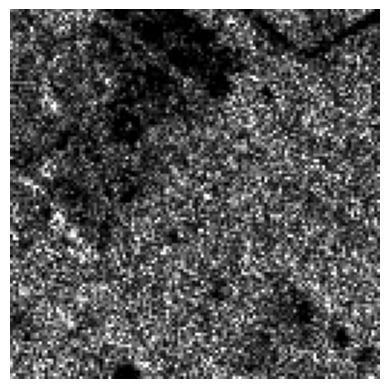

True


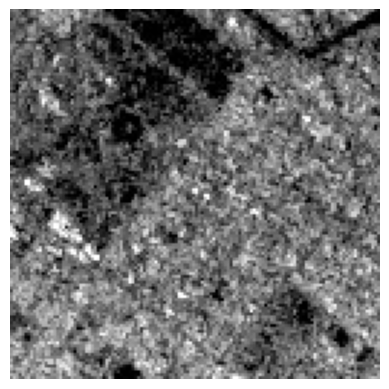

Denoised
Error: File results/bsd68_loss_L1_view_L5_LM/im5.bmp not found.

 Image 6 

Noisy


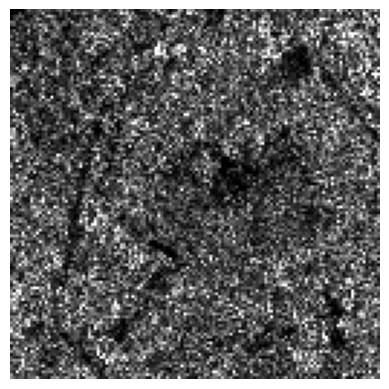

True


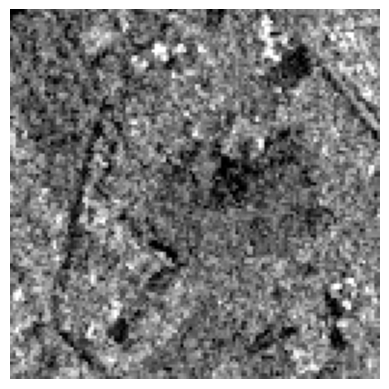

Denoised
Error: File results/bsd68_loss_L1_view_L5_LM/im6.bmp not found.


In [49]:
model_name="loss_L1_view_L5_LM"
for ind_im in range(7):
  plot_results(model_name,ind_im)

Results with the Oracle method


 Image 0 

Noisy


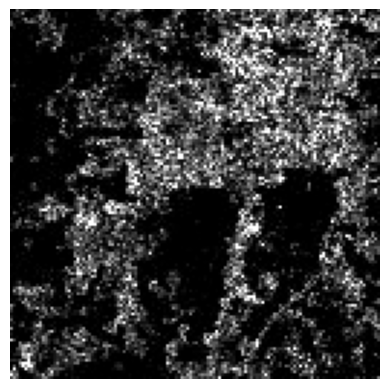

True


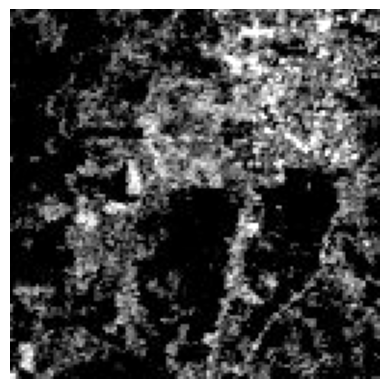

Denoised
Error: File results/bsd68_loss_L1_view_L5/im0.bmp not found.

 Image 1 

Noisy


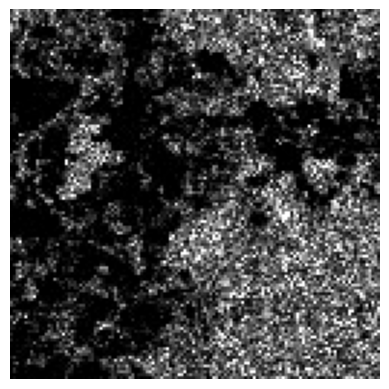

True


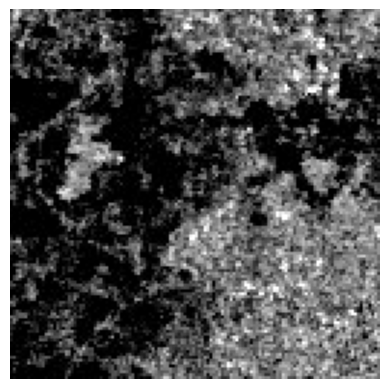

Denoised
Error: File results/bsd68_loss_L1_view_L5/im1.bmp not found.

 Image 2 

Noisy


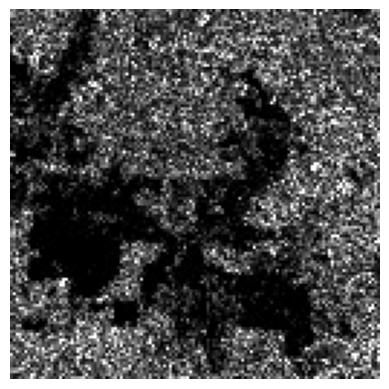

True


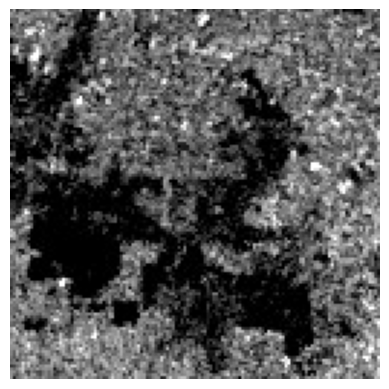

Denoised
Error: File results/bsd68_loss_L1_view_L5/im2.bmp not found.

 Image 3 

Noisy


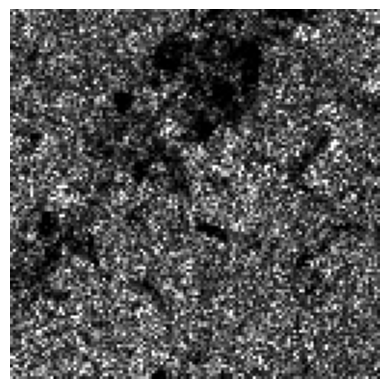

True


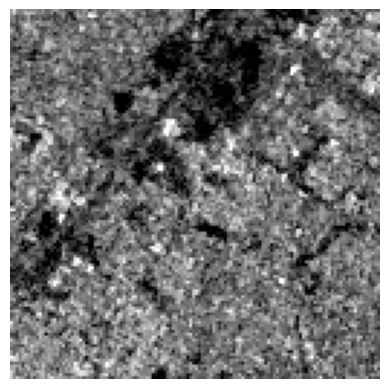

Denoised
Error: File results/bsd68_loss_L1_view_L5/im3.bmp not found.

 Image 4 

Noisy


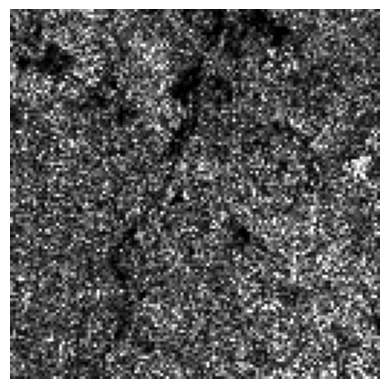

True


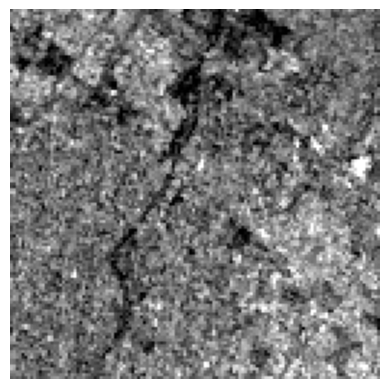

Denoised
Error: File results/bsd68_loss_L1_view_L5/im4.bmp not found.

 Image 5 

Noisy


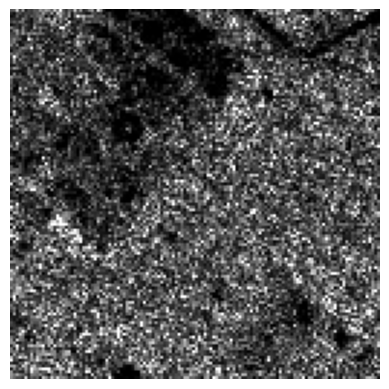

True


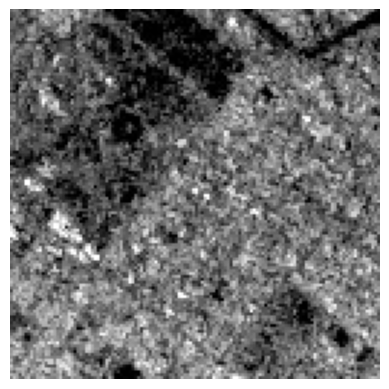

Denoised
Error: File results/bsd68_loss_L1_view_L5/im5.bmp not found.

 Image 6 

Noisy


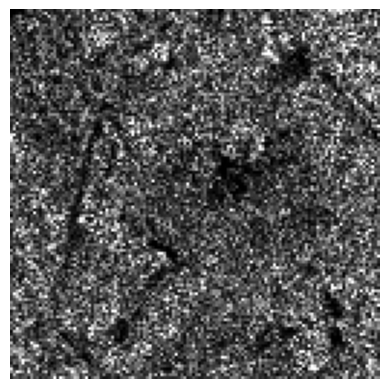

True


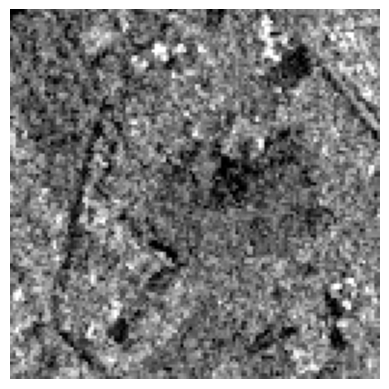

Denoised
Error: File results/bsd68_loss_L1_view_L5/im6.bmp not found.


In [33]:
model_name="loss_L1_view_L5"

for ind_im in range(7):
  plot_results(model_name,ind_im)